# #30DayChartChallenge: Polar Plot Time Series of Modelled Salt Front in the Delaware Bay

### Libraries

In [201]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy
import numpy as np
from datetime import datetime
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import cmocean
import cmocean.cm as cmo
import dask.array as da
import scipy.io
from scipy import signal
import os

### Import Salt Front Data

Read 2016 data

In [23]:
saltfront_2016 = pd.read_csv('saltfront_2016.csv', index_col=0 )
saltfront_2016['date'] = pd.to_datetime(saltfront_2016.index)

Read 2019 data

In [2]:
saltfront_2019 = pd.read_csv('saltfront_2019.csv', index_col=0 )
saltfront_2019['date'] = pd.to_datetime(saltfront_2019.index)

Plot 2016

### Setup 2016 Data for Plotting 

In [245]:
df_plot_2016 = saltfront_2016
df_plot_2016['year'] = df_plot_2016.date.dt.year # Add column for year

In [246]:
# Get list of years represented in the dataset
year_listed = df_plot_2016.year.unique()
year_listed

array([2016], dtype=int64)

In [247]:
# Make sure the data covers complete years for all years in the dataset
year_df_idx = pd.date_range(f'01-01-{year_listed[0]}',f'12-31-{year_listed[-1]}', freq='1H')
df_plot_2016.index = pd.DatetimeIndex(df_plot_2016.index)
df_plot_2016 = df_plot_2016.reindex(year_df_idx, fill_value=np.nan)
df_plot_2016['date'] = pd.to_datetime(df_plot_2016.index)

In [248]:
# Upsample to hourly - using linear interpolation to fill dist_mile values
new_idx_2016 = pd.date_range(df_plot_2016.date.min(), df_plot_2016.date.max(), freq='1H') # hourly index
df_plot_2016 = df_plot_2016.reindex(new_idx_2016, fill_value=np.nan)
df_plot_2016['dist_mile'] = df_plot_2016['dist_mile'].interpolate(method='linear') # linearly interpolate between daily means
df_plot_2016['date'] = pd.DatetimeIndex(df_plot_2016.index)

In [249]:
# Add time-related columns
df_plot_2016['year'] = df_plot_2016.date.dt.year # Add column for year
df_plot_2016['mdate'] = mdates.date2num(df_plot_2016.index.to_pydatetime()) # Convert dates to matplotlib dates
df_plot_2016['tnorm'] = np.nan # for now, set normalized time column to NaN
df_plot_2016['doy'] = df_plot_2016.date.dt.dayofyear # compute doy #option 2
df_plot_2016['doy_norm'] = np.nan # for now, set normalized doy column to NaN

In [250]:
# For each year in the dataset
for year in year_listed:
    year_df =  df_plot_2016.loc[df_plot_2016['year']==year]
    # normalize dates for that year to circle (2pi radians)
    df_plot_2016.loc[df_plot_2016['year']==year, 'tnorm'] = (year_df['mdate']-year_df['mdate'].min())/(year_df['mdate'].max()-year_df['mdate'].min())*2.*np.pi
    # normalize DOY for that year to circle (2pi radians)
    df_plot_2016.loc[df_plot_2016['year']==year, 'doy_norm'] = (year_df['doy']-year_df['doy'].min())/(year_df['doy'].max()-year_df['doy'].min())*2.*np.pi

In [251]:
# Use an arbitrary year to get a set of dates for labeling at 8 places around polar chart
# dates_df = pd.DataFrame({'date':pd.date_range(start='2019-01-01', end='2019-12-31')})
dates_df = pd.DataFrame({'date':pd.date_range(start='2016-01-01', end='2016-12-26')})
date_labels = []
for i in range(0,8):
    date_labels.append(dates_df.iloc[round((dates_df.shape[0]/8)*i)].date.strftime("%m/%d"))
date_labels

['01/01', '02/15', '03/31', '05/15', '06/29', '08/14', '09/28', '11/12']

In [252]:
# Get series representing Wilmington river mile
rm_Wilmington = df_plot_2016.copy()
rm_Wilmington['dist_mile'] = 70

In [253]:
# Get series representing south Philadelphia river mile
rm_Philadelphia = df_plot_2016.copy()
rm_Philadelphia['dist_mile'] = 91

In [254]:
# Get series representing north Philadelphia river mile
rm_Philadelphia_max = df_plot_2016.copy()
rm_Philadelphia_max['dist_mile'] = 110

In [255]:
# Set y bound (y axis limits) to be used in both plots
y_bounds = [min(df_plot_2016.dist_mile.min(),df_plot_2019.dist_mile.min())-8, max(df_plot_2016.dist_mile.max(), df_plot_2019.dist_mile.max())+5]
y_bounds

[38.77466698064672, 93.58496888557525]

In [256]:
# https://nbviewer.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form numlines x (points per line) x 2 (x and y) array
    '''
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    return segments

# Interface to LineCollection:
def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"): # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

### Plot 2016 Data

C:\Users\TTHOMP~1\AppData\Local\Temp\1/ipykernel_34352/1334796212.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(date_labels)


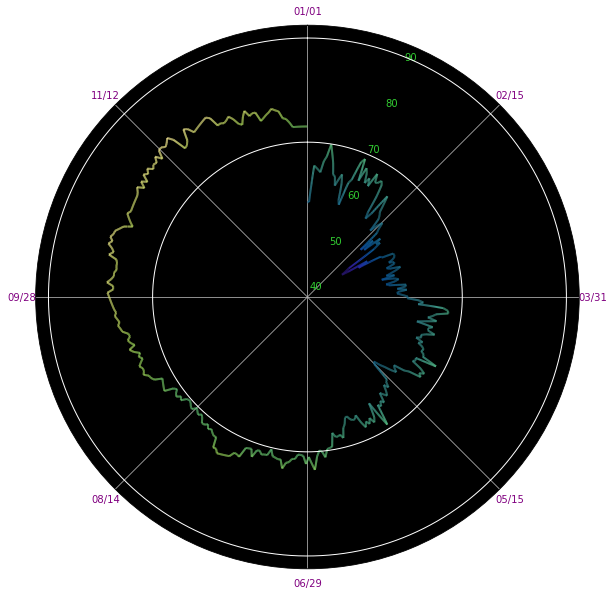

In [257]:
# Plot w/ normalized date
import matplotlib.colors
import matplotlib.cm
fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111, projection='polar')
ax1.set_theta_direction(-1)
ax1.set_theta_zero_location("N")
norm = plt.Normalize(df_plot_2016.dist_mile.min(), df_plot_2016.dist_mile.max())
for year in year_listed:
    lc = colorline(df_plot_2016.loc[df_plot_2016['year']==year].tnorm, df_plot_2016.loc[df_plot_2016['year']==year].dist_mile, cmap=cmo.haline, linewidth=2, norm=norm)
    lc.set_array(df_plot_2016.loc[df_plot_2016['year']==year].dist_mile)
ax1.plot(rm_Wilmington['tnorm'],rm_Wilmington['dist_mile'] , linewidth=1, color='white')
ax1.plot(rm_Philadelphia['tnorm'],rm_Philadelphia['dist_mile'] , linewidth=1, color='white')
ax1.tick_params(axis='y', colors='limegreen')
ax1.tick_params(axis='x', colors='purple')
ax1.set_ylim(y_bounds)
ax1.set_xticklabels(date_labels)
# ax1.set_yticklabels([])
ax1.set_facecolor('black')
ax1.grid(False, axis='y')
plt.show()
fig.savefig('polar_plot_saltfront_2016.png', dpi=300, transparent=True)

### Setup 2019 Data for Plotting 

In [258]:
df_plot_2019 = saltfront_2019
df_plot_2019['year'] = df_plot_2019.date.dt.year # Add column for year

In [259]:
# Get list of years represented in the dataset
year_listed = df_plot_2019.year.unique()
year_listed

array([2019], dtype=int64)

In [260]:
# Make sure the data covers complete years for all years in the dataset
year_df_idx = pd.date_range(f'01-01-{year_listed[0]}',f'12-31-{year_listed[-1]}', freq = '1H')
df_plot_2019.index = pd.DatetimeIndex(df_plot_2019.index)
df_plot_2019 = df_plot_2019.reindex(year_df_idx, fill_value=np.nan)
df_plot_2019['date'] = pd.to_datetime(df_plot_2019.index)

Upsample data to hourly for smoother transition

In [261]:
# Upsample to hourly - using linear interpolation to fill dist_mile values
new_idx_2019 = pd.date_range(df_plot_2019.date.min(), df_plot_2019.date.max(), freq='1H') # hourly index
df_plot_2019 = df_plot_2019.reindex(new_idx_2019, fill_value=np.nan)
df_plot_2019['dist_mile'] = df_plot_2019['dist_mile'].interpolate(method='linear') # linearly interpolate between daily means
df_plot_2019['date'] = pd.DatetimeIndex(df_plot_2019.index)

In [262]:
# Add time-related columns
df_plot_2019['year'] = df_plot_2019.date.dt.year # Add column for year
df_plot_2019['mdate'] = mdates.date2num(df_plot_2019.index.to_pydatetime()) # Convert dates to matplotlib dates
df_plot_2019['tnorm'] = np.nan # for now, set normalized time column to NaN
df_plot_2019['doy'] = df_plot_2019.date.dt.dayofyear # compute doy #option 2
df_plot_2019['doy_norm'] = np.nan # for now, set normalized doy column to NaN

In [263]:
# For each year in the dataset
for year in year_listed:
    year_df = df_plot_2019.loc[df_plot_2019['year']==year]
    # normalize dates for that year to circle (2pi radians)
    df_plot_2019.loc[df_plot_2019['year']==year, 'tnorm'] = (year_df['mdate']-year_df['mdate'].min())/(year_df['mdate'].max()-year_df['mdate'].min())*2.*np.pi
    # normalize DOY for that year to circle (2pi radians)
    df_plot_2019.loc[df_plot_2019['year']==year, 'doy_norm'] = (year_df['doy']-year_df['doy'].min())/(year_df['doy'].max()-year_df['doy'].min())*2.*np.pi

In [264]:
# Use an arbitrary year to get a set of dates for labeling at 8 places around polar chart
# dates_df = pd.DataFrame({'date':pd.date_range(start='2019-01-01', end='2019-12-31')})
dates_df = pd.DataFrame({'date':pd.date_range(start='2019-01-01', end='2019-12-26')})
date_labels = []
for i in range(0,8):
    date_labels.append(dates_df.iloc[round((dates_df.shape[0]/8)*i)].date.strftime("%m/%d"))
date_labels

['01/01', '02/15', '04/01', '05/16', '06/30', '08/14', '09/28', '11/12']

In [265]:
# Get series representing Wilmington river mile
rm_Wilmington = df_plot_2019.copy()
rm_Wilmington['dist_mile'] = 70

In [266]:
# Get series representing south Philadelphia river mile
rm_Philadelphia = df_plot_2019.copy()
rm_Philadelphia['dist_mile'] = 91

In [267]:
# Get series representing north Philadelphia river mile
rm_Philadelphia_max = df_plot_2019.copy()
rm_Philadelphia_max['dist_mile'] = 110

### Plot 2019 Data

C:\Users\TTHOMP~1\AppData\Local\Temp\1/ipykernel_34352/2784739934.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(date_labels)


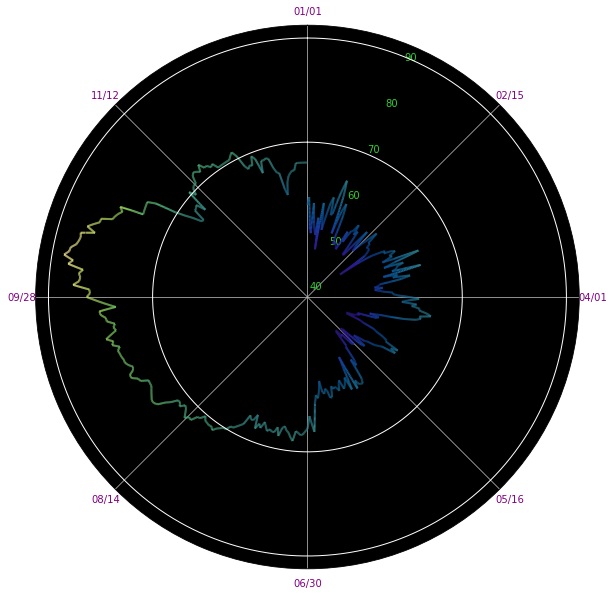

In [269]:
# Plot w/ normalized date
import matplotlib.colors
import matplotlib.cm
fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111, projection='polar')
ax1.set_theta_direction(-1)
ax1.set_theta_zero_location("N")
norm = plt.Normalize(df_plot_2019.dist_mile.min(), df_plot_2019.dist_mile.max())
for year in year_listed:
    lc = colorline(df_plot_2019.loc[df_plot_2019['year']==year].tnorm, df_plot_2019.loc[df_plot_2019['year']==year].dist_mile, cmap=cmo.haline, linewidth=2, norm=norm)
    lc.set_array(df_plot_2019.loc[df_plot_2019['year']==year].dist_mile)
ax1.plot(rm_Wilmington['tnorm'],rm_Wilmington['dist_mile'] , linewidth=1, color='white')
ax1.plot(rm_Philadelphia['tnorm'],rm_Philadelphia['dist_mile'] , linewidth=1, color='white')
ax1.tick_params(axis='y', colors='limegreen')
ax1.tick_params(axis='x', colors='purple')
ax1.set_ylim(y_bounds)
ax1.set_xticklabels(date_labels)
# ax1.set_yticklabels([])
ax1.set_facecolor('black')
ax1.grid(False, axis='y')
plt.show()
fig.savefig('polar_plot_saltfront_2019.png', dpi=300, transparent=True)

### Site Maps

In [36]:
url = 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/users/scook/proj/DE_Bay/run07/run07E/run07E_bulk/ocean_deb_his_run07E_bulk_00012.nc'

with xr.set_options(file_cache_maxsize=10):
    ds = xr.open_dataset(url, chunks={'ocean_time':1})

In [54]:
ds.salt

<xarray.DataArray 'salt' (ocean_time: 720, s_rho: 16, eta_rho: 1370, xi_rho: 184)>
dask.array<open_dataset-54c6206aad91510257859278089f5fa4salt, shape=(720, 16, 1370, 184), dtype=float32, chunksize=(1, 16, 1370, 184), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9688 -0.9062 -0.8438 ... -0.09375 -0.03125
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(1370, 184), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(1370, 184), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2016-11-26T01:00:00 ... 2016-12-26
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  salinity
    time:       ocean_time
    grid:       grid
    location:   face
    field:      salinity, scalar, series

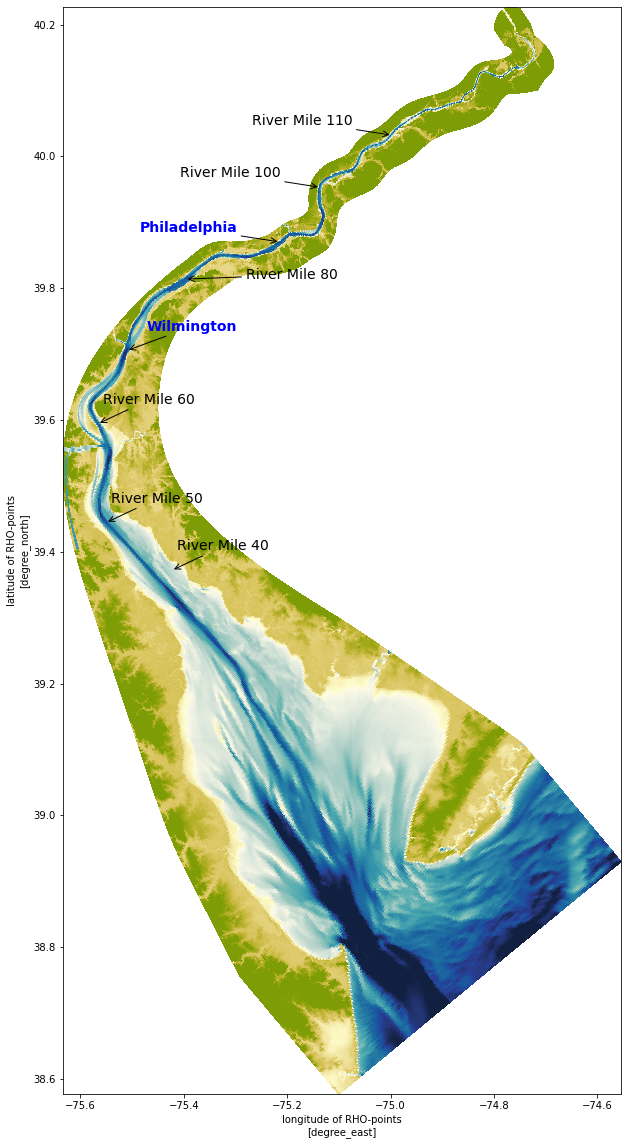

In [334]:
fig, ax = plt.subplots(figsize=(10,20))

newcmap = cmocean.cm.tools.crop(cmocean.cm.delta,vmin=-45,vmax=20,pivot=0)

d = -1*ds['h']
p1 = d.plot(ax=ax,x='lon_rho', y='lat_rho',cmap=newcmap,vmin=-20,vmax=5,add_colorbar=False)

ax.annotate("River Mile 40", xy=(-75.42278348, 39.3719356), xytext=(5, 20), xycoords='data', textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'), fontsize=14)
ax.annotate("River Mile 50", xy=(-75.55029363, 39.44428867), xytext=(5, 20), xycoords='data', textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'), fontsize=14)
ax.annotate("River Mile 60", xy=(-75.56594782, 39.59425391), xytext=(5, 20), xycoords='data', textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'), fontsize=14)
ax.annotate("Wilmington", xy=(-75.50988311, 39.70539838), weight='bold', color='blue', xytext=(20, 20), xycoords='data', textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'), fontsize=14)
ax.annotate("River Mile 80", xy=(-75.3967617, 39.81370734), xytext=(60, 0), xycoords='data', textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'), fontsize=14)
ax.annotate("Philadelphia", xy=(-75.21498773, 39.87019746), weight='bold', color='blue', xytext=(-140, 10), xycoords='data', textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'), fontsize=14)
ax.annotate("River Mile 100", xy=(-75.13662427, 39.95302179), xytext=(-140, 10), xycoords='data', textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'), fontsize=14)
ax.annotate("River Mile 110", xy=(-74.99779842, 40.0320903), xytext=(-140, 10), xycoords='data', textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'), fontsize=14)

plt.savefig('site_map_closeup.png',transparent=True)
# plt.tight_layout()

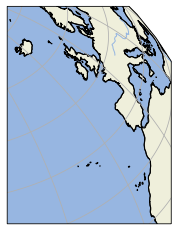

In [114]:
central_lon, central_lat = -75.201416, 39.455282
extent = [-40, 20, 30, 60]
ax = plt.axes(projection=ccrs.Orthographic(central_lon, central_lat))
ax.set_extent(extent)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.gridlines()
ax.coastlines(resolution='50m')